In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import pyro

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import scipy.stats as stats 

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
from pyro.infer import MCMC, NUTS

In [ ]:
business_df = pd.read_csv('../datasets/Transformed_Dataset.csv')

In [ ]:
business_df.shape

In [ ]:
print('have histograms based if it is economy class')

business_df.hist('price', bins=50, by=business_df['Economy'], sharey=True, sharex=True)

In [ ]:
business_df.hist('price', bins=70)

In [ ]:
train_x, test_x, train_y,test_y = train_test_split(business_df['Economy'], business_df['price'], test_size=0.2, random_state=488)

In [ ]:
x_train_clean = torch.tensor(train_x.to_numpy(dtype=np.int_)) #business_df['Economy']
y_train_clean = torch.tensor(train_y.values)

In [ ]:
x_test_clean = torch.tensor(test_x.to_numpy(dtype=np.int_)) #business_df['Economy']
y_test_clean = torch.tensor(test_y.values)

In [ ]:
x_train = torch.tensor(train_x.to_numpy(dtype=np.int_))
y_train = torch.tensor(train_y.values)

In [ ]:
x_train_clean.count_nonzero(), len(x_train_clean)

In [ ]:
# priors for components
mu_loc = torch.tensor([4500., 55000.])
mu_scale = torch.tensor([100., 100.])
sigma_scale = torch.tensor([10., 10.])
with pyro.plate('components', 2):
    mu = pyro.sample('mu', pyro.distributions.Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
    sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
    
#with pyro.plate('data', len(y)):
#    #buss = pyro.sample('busi', pyro.distributions.Bernoulli(x), infer={"enumerate":"parallel"}).long()
#    buss = x
#    price = pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]), obs=y)

In [ ]:
buss = 0
pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]))

In [ ]:
def first_model(x=None, y=None):
    # priors for components
    #pi = pyro.sample('pi', pyro.distributions.Beta(2.,2.))
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([1., 1.])
    sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        mu = pyro.sample('mu', pyro.distributions.Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
        
    with pyro.plate('data', len(y)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(pi), infer={"enumerate":"parallel"}).long()
        buss = x
        price = pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]), obs=y)
    
    return price
    

In [ ]:
def first_model(x=None, y=None):
    # priors for components
    #pi = pyro.sample('pi', pyro.distributions.Beta(2.,2.))
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([3., 3.])
    sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        mu = pyro.sample('mu', pyro.distributions.HalfCauchy(mu_scale))#Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
        
    with pyro.plate('data', len(y)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(pi), infer={"enumerate":"parallel"}).long()
        buss = x
        #price = pyro.sample('price', pyro.distributions.Chi2(mu[buss]), obs=y)
        price = pyro.sample('price', pyro.distributions.Gamma(mu[buss],sigma[buss]), obs=y)
    
    return price

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(first_model)
mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=200, num_chains=1)
mcmc.run(x_train_clean,y_train_clean)

# Show summary of inference results
mcmc.summary()

In [ ]:
posterior_samples = mcmc.get_samples()
print(posterior_samples.keys())

In [ ]:
print(posterior_samples['mu'][0].shape)

sns.histplot(posterior_samples['mu'][0], kde=True, bins=40)
plt.show()

## first attempt:

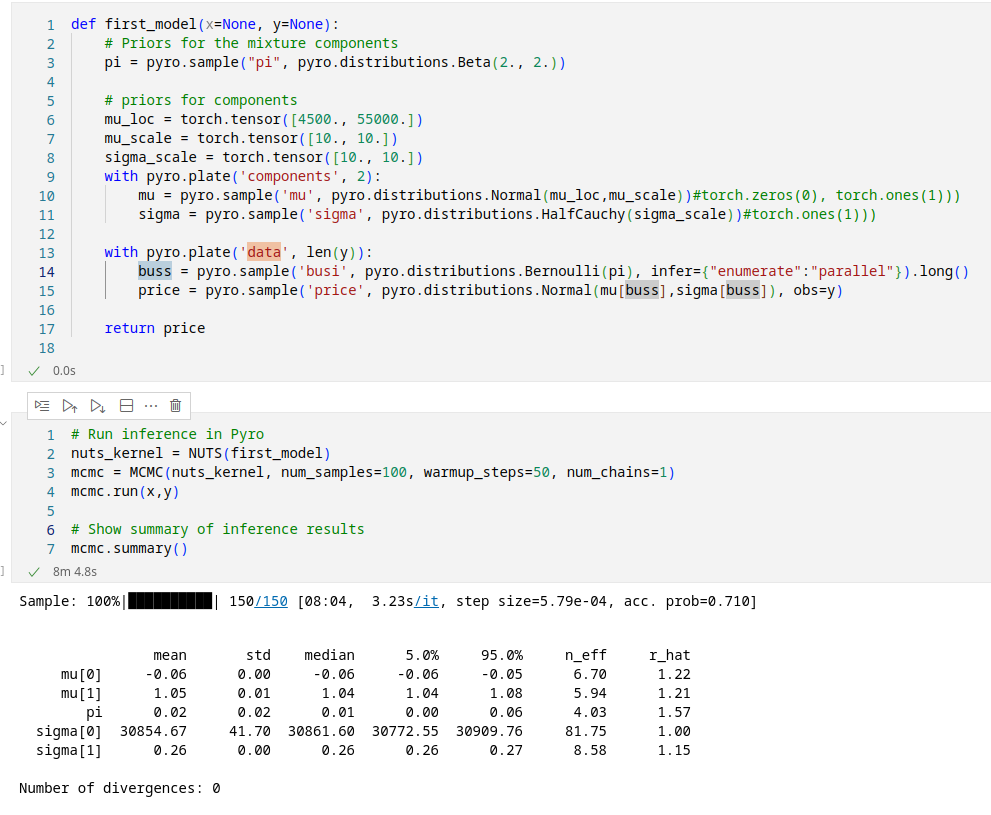

## second attempt:
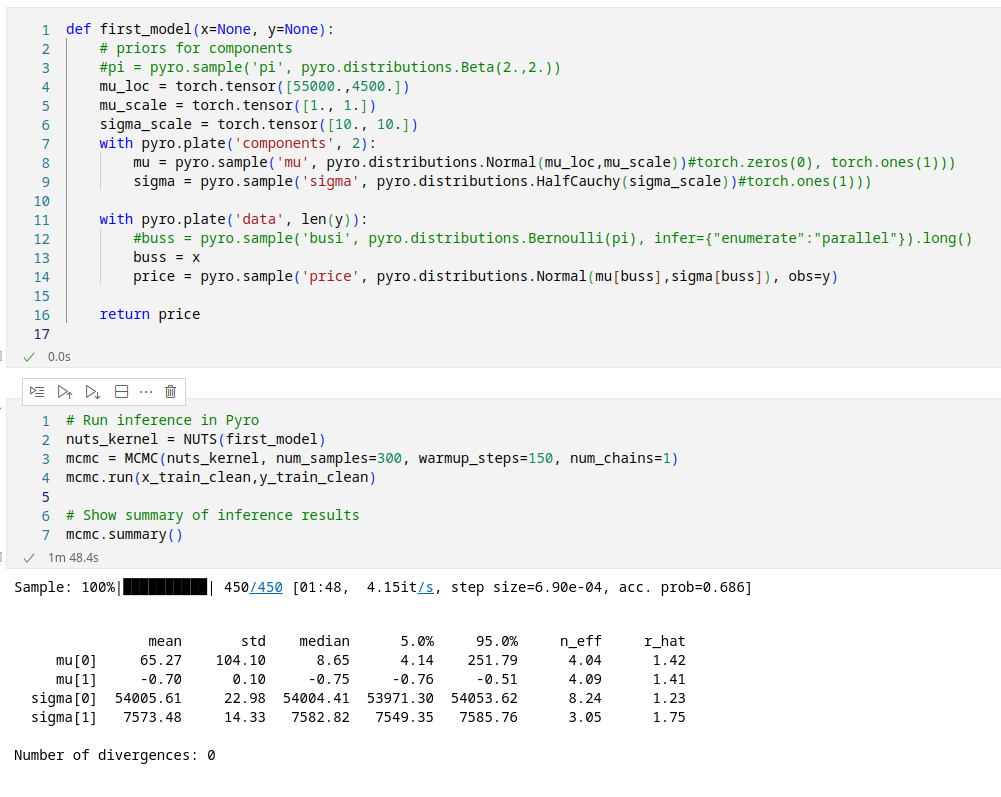

## third attempt
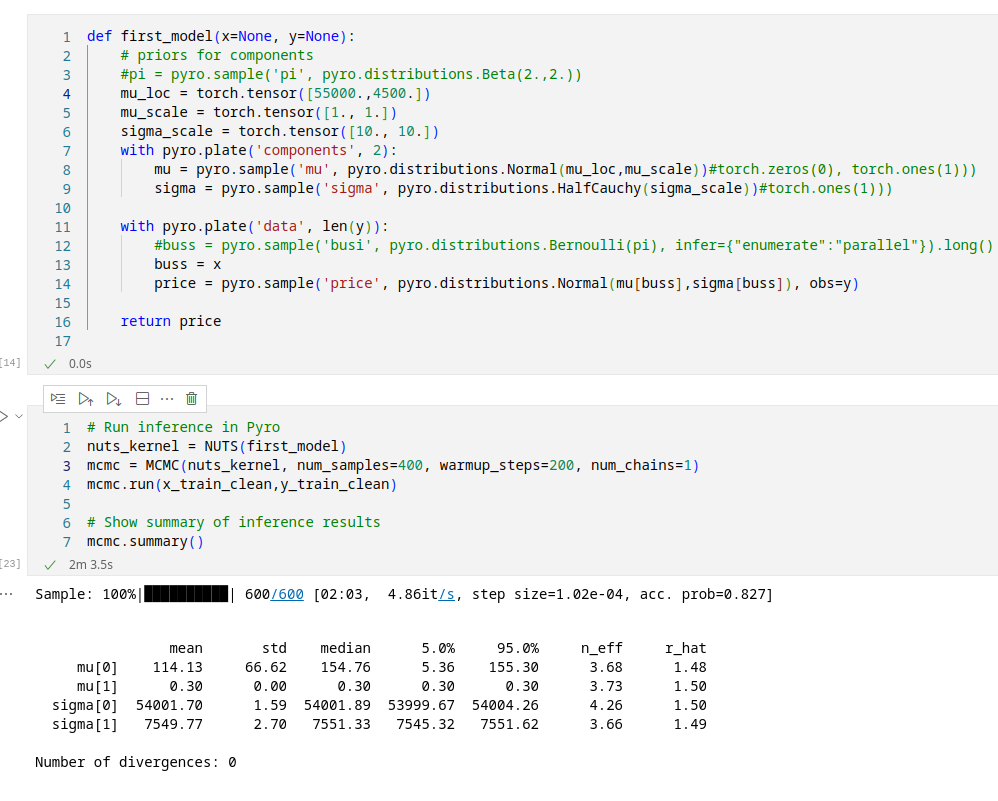

## trying out Gamma
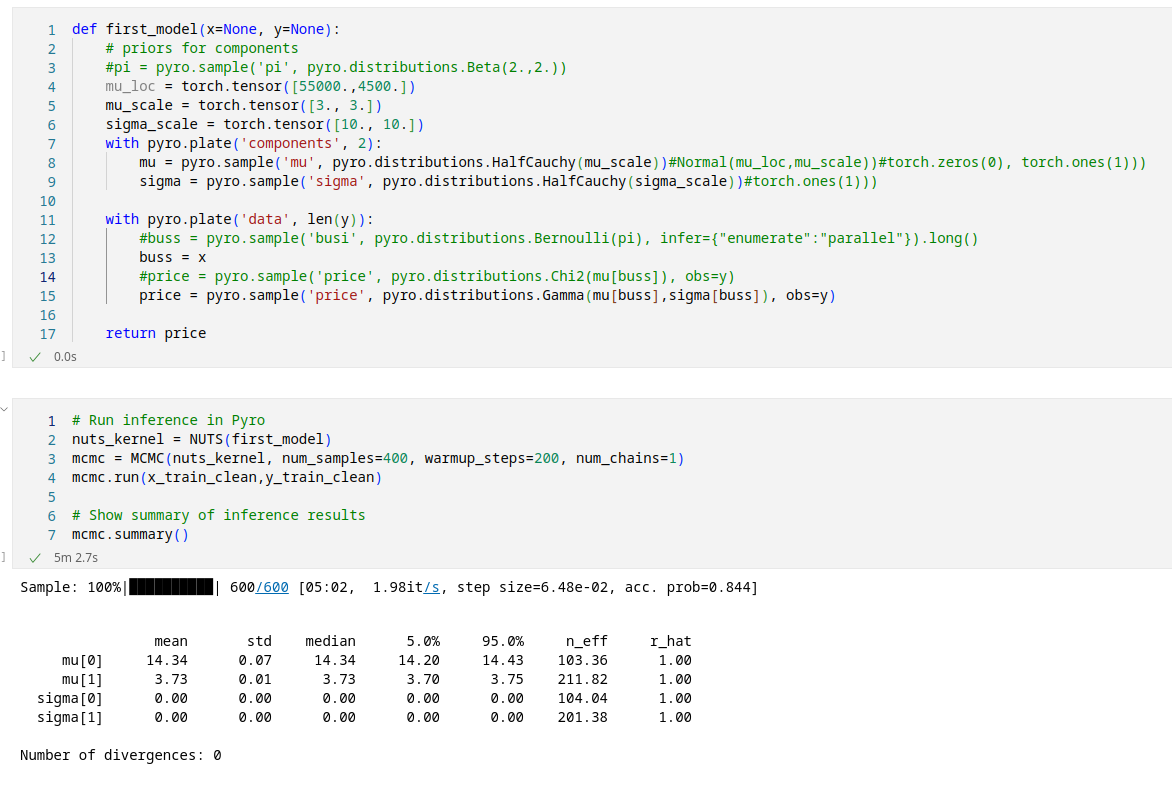

# make predictions

In [ ]:
def first_model_pred(x=None, y=None):
    # priors for components
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([1., 1.])
    sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        mu = pyro.sample('mu', pyro.distributions.Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
        
    with pyro.plate('data', len(y)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(x), infer={"enumerate":"parallel"}).long()
        buss = x
        price = pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]), obs=y)
    price_pred = pyro.sample('price_pred', pyro.distributions.Normal(mu[buss],sigma[buss]))
    return price_pred

In [ ]:
def first_model(x=None, y=None):
    # priors for components
    #pi = pyro.sample('pi', pyro.distributions.Beta(2.,2.))
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([3., 3.])
    sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        mu = pyro.sample('mu', pyro.distributions.HalfCauchy(mu_scale))#Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
        
    with pyro.plate('data', len(y)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(pi), infer={"enumerate":"parallel"}).long()
        buss = x
        #price = pyro.sample('price', pyro.distributions.Chi2(mu[buss]), obs=y)
        pyro.sample('price', pyro.distributions.Gamma(mu[buss],sigma[buss]), obs=y)
    price_pred = pyro.sample('price_pred', pyro.distributions.Gamma(mu[buss],sigma[buss]))
    return price_pred

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(first_model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, num_chains=1)
mcmc.run(x_train_clean,y_train_clean)

# Show summary of inference results
mcmc.summary()

In [ ]:
def pred(x, post_samples):
    return pyro.sample('prediction',pyro.distributions.Normal(post_samples['mu'].mean(dim=0)[x],post_samples['sigma'].mean(dim=0)[x]))

In [ ]:
def pred_gamma(x, post_samples):
    return pyro.sample('prediction',pyro.distributions.Gamma(post_samples['mu'].mean(dim=0)[x],post_samples['sigma'].mean(dim=0)[x]))

In [ ]:
posterior_samples = mcmc.get_samples()

In [ ]:
posterior_samples['mu'].mean(dim=0)[1], posterior_samples['sigma'].mean(dim=0)[1]

In [ ]:
business = pyro.distributions.Gamma(torch.tensor(14.3093), torch.tensor(0.0003)).sample_n(74938,)
economy = pyro.distributions.Gamma(torch.tensor(3.7298), torch.tensor(0.0006)).sample_n(165184,)

In [ ]:
sns.histplot(business, bins=30, kde=True)
sns.histplot(economy, bins=30, kde=True)

plt.show()

In [ ]:
pred_gamma([0,1],posterior_samples), pred_gamma([0,1],posterior_samples)

In [ ]:
posterior_samples['mu'][0]
posterior_samples['sigma'][0]

In [ ]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
pred_gamma(1,posterior_samples)

In [ ]:
test_x

In [ ]:
pred_y = pred_gamma(x_test_clean, posterior_samples)

corr, mae, rae, rmse, r2 = compute_error(y_test_clean.numpy(),pred_y.numpy())

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
#type(pred_y.numpy()), type(y_test_clean.numpy())